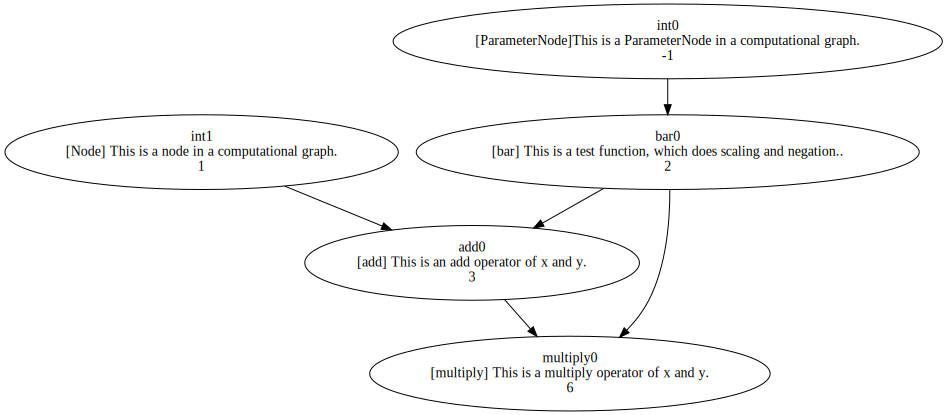

In [1]:
# Simple debugging example
from autogen.trace import trace, trace_op
from autogen.trace.nodes import ParameterNode
from autogen.trace.propagators import function_propagate
from autogen.trace.utils import get_name


@trace_op()
def bar(x):
    "This is a test function, which does scaling and negation."
    y = x * 2
    return -y


def foo(x):
    y = x + 1
    return x * y


def user(x):
    if x < 100:
        return "The number needs be larger."
    else:
        return "Success."


# Test function propagate
x = ParameterNode(-1)
visualize = True

propagate = function_propagate()
output = foo(bar(x))
feedback = user(output.data)
x.zero_feedback()
output.backward(feedback, propagate=propagate, visualize=visualize)

In [2]:
summary = propagate.summarize(x)

print("Graph summary:")
for k, v in sorted(summary["graph"]):
    print("  ", v)

print("Function definitions:")
for k, v in summary["doc"].items():
    print("  ", v)

print("Data:")
for k, v in summary["data"].items():
    print("  ", f"{k}={v}")

print("User feedback")
print("  ", summary["user_feedback"])

Graph summary:
   bar0 = bar(int0)
   add0 = add(bar0, int1)
   multiply0 = multiply(bar0, add0)
Function definitions:
   [bar] This is a test function, which does scaling and negation..
   [multiply] This is a multiply operator of x and y.
   [add] This is an add operator of x and y.
Data:
   bar0=2
   multiply0=6
   add0=3
   int0=-1
User feedback
   The number needs be larger.
